## Modle RESNET + LSTM

In [1]:
import pandas as pd
import numpy as np 
from datasets import load_dataset

# the 4th data split
data = load_dataset("jmhessel/newyorker_caption_contest", "explanation_4")
df_train = pd.DataFrame(data['train'])
df_test = pd.DataFrame(data['test'])
df_val = pd.DataFrame(data['validation'])


In [2]:
df_train.head(2)

,image,contest_number,image_location,image_description,image_uncanny_description,entities,questions,caption_choices,from_description,label,n_tokens_label,instance_id
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,721,a sandbox,A kid makes a sand very tall tower with someon...,It is not usual that kids make sand towers ove...,[https://en.wikipedia.org/wiki/Sand_art_and_pl...,[Why did the kid make the tower?],I'm starting to regret that haircut.,scene: a sandbox description: A kid makes a sa...,A reference to the fairy tale Rapunzel: in tha...,73,24fc00eca85363265c95fcc13bea5d37
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,13,a bedroom,A couple are lying on a bed together. The man...,It's unusual for a man to be lying in bed dres...,"[https://en.wikipedia.org/wiki/Foreplay, https...",[Why is that man dressed like that?],"Okay. Now you be the naughty mosquito, and I'l...",scene: a bedroom description: A couple are lyi...,A literal enumeration that pokes fun at the sp...,65,ac48a0768134071dbd9db3e5c64ec96d


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add

# Combine all captions for tokenizer
all_captions = df_train['image_description'].tolist() + df_val['image_description'].tolist() + df_test['image_description'].tolist()

# Tokenize the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Function to convert captions to sequences
def captions_to_sequences(captions):
    sequences = tokenizer.texts_to_sequences(captions)
    return pad_sequences(sequences, padding='post')

# Convert captions to sequences
train_sequences = captions_to_sequences(df_train['image_description'])
val_sequences = captions_to_sequences(df_val['image_description'])
test_sequences = captions_to_sequences(df_test['image_description'])

# Get the maximum caption length
max_length = max(len(seq) for seq in train_sequences)


2024-05-29 12:03:32.335217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 12:03:32.430935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 12:03:32.432642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 12:03:33.385278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.models import Model

# Function to preprocess and extract features from PIL image objects
def preprocess_and_extract_features(image_objects):
    base_model = ResNet50(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

    features_list = [] 
    for img in image_objects:
        try:
            # Ensure image is in RGB format
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            image = img.resize((224, 224))            
            img_array = np.array(image)            
            img_array = np.expand_dims(img_array, axis=0)                        
            img_array = preprocess_input(img_array)            
            features = model.predict(img_array)            
            features_list.append(features.flatten())     

        except Exception as e:
            print(f"Error processing image: {e}")
            features_list.append(None)  # Append None if there is an error

    return np.array(features_list)

# Extract features for train, val, and test sets
train_images = df_train['image'].tolist()
val_images = df_val['image'].tolist()
test_images = df_test['image'].tolist()

train_features = preprocess_and_extract_features(train_images)
val_features = preprocess_and_extract_features(val_images)
test_features = preprocess_and_extract_features(test_images)

# Remove rows where image features could not be extracted
train_df = df_train.iloc[[i for i, f in enumerate(train_features) if f is not None]]
val_df = df_val.iloc[[i for i, f in enumerate(val_features) if f is not None]]
test_df = df_test.iloc[[i for i, f in enumerate(test_features) if f is not None]]

# Convert image features to numpy arrays
train_features = np.array([f for f in train_features if f is not None])
val_features = np.array([f for f in val_features if f is not None])
test_features = np.array([f for f in test_features if f is not None])

print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


1/1 [==============================] - 0s 64ms/step
Train features shape: (2340, 100352)
Validation features shape: (131, 100352)
Test features shape: (130, 100352)


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, add, RepeatVector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image


# Step 1: Prepare the data (already done previously)
max_length = 25
vocab_size = 10000  # Adjust based on your data
embedding_dim = 256
units = 256

# Tokenize captions
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_df['image_description'])

train_seqs = tokenizer.texts_to_sequences(train_df['image_description'])
val_seqs = tokenizer.texts_to_sequences(val_df['image_description'])
test_seqs = tokenizer.texts_to_sequences(test_df['image_description'])

train_seqs = pad_sequences(train_seqs, maxlen=max_length, padding='post')
val_seqs = pad_sequences(val_seqs, maxlen=max_length, padding='post')
test_seqs = pad_sequences(test_seqs, maxlen=max_length, padding='post')



In [6]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Concatenate, RepeatVector, Reshape
from tensorflow.keras.models import Model

# Define the model architecture
def build_model(max_length, vocab_size, embedding_dim, units, image_feature_dim):
    # Image input
    image_input = Input(shape=(image_feature_dim,))
    
    # Text input
    text_input = Input(shape=(max_length,))
    
    # Reshape image features to match the shape of text embeddings
    image_features = Reshape((1, image_feature_dim))(image_input)
    
    # Repeat image features to match the sequence length
    image_features = LSTM(units, return_sequences=False)(image_features)
    image_features = RepeatVector(max_length)(image_features)
    
    # Text embedding
    text_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
    text_embedding = LSTM(units, return_sequences=True)(text_embedding)
    
    # Concatenate image and text features
    combined_features = Concatenate(axis=-1)([image_features, text_embedding])
    
    # LSTM layer
    lstm_out = LSTM(units, return_sequences=True)(combined_features)
    
    # Dropout for regularization
    lstm_out = Dropout(0.5)(lstm_out)
    
    # Output layer
    output = Dense(vocab_size, activation='softmax')(lstm_out)
    
    # Define the model
    model = Model(inputs=[image_input, text_input], outputs=output)
    
    return model

# Define model parameters
max_length = 25  # Length of input sequences
vocab_size = 10000  # Vocabulary size
embedding_dim = 256  # Dimension of word embeddings
units = 256  # Number of units in LSTM layers
image_feature_dim = 100352  # Dimension of image features

# Build the model
model = build_model(max_length, vocab_size, embedding_dim, units, image_feature_dim)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [7]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100352)]             0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 100352)            0         ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 256)                  1030236   ['reshape[0][0]']             
                                                          16                                

Epoch 1/50
65/65 [==============================] - 33s 380ms/step - loss: 6.4273 - val_loss: 5.8231
Epoch 2/50
65/65 [==============================] - 22s 339ms/step - loss: 5.7354 - val_loss: 5.7450
Epoch 3/50
65/65 [==============================] - 22s 344ms/step - loss: 5.6045 - val_loss: 5.5540
Epoch 4/50
65/65 [==============================] - 22s 342ms/step - loss: 5.4178 - val_loss: 5.3623
Epoch 5/50
65/65 [==============================] - 22s 341ms/step - loss: 5.2627 - val_loss: 5.2082
Epoch 6/50
65/65 [==============================] - 22s 340ms/step - loss: 5.1016 - val_loss: 5.0431
Epoch 7/50
65/65 [==============================] - 22s 340ms/step - loss: 4.9083 - val_loss: 4.7926
Epoch 8/50
65/65 [==============================] - 22s 344ms/step - loss: 4.7120 - val_loss: 4.6261
Epoch 9/50
65/65 [==============================] - 22s 340ms/step - loss: 4.4916 - val_loss: 4.3752
Epoch 10/50
65/65 [==============================] - 22s 341ms/step - loss: 4.2763 - val_lo

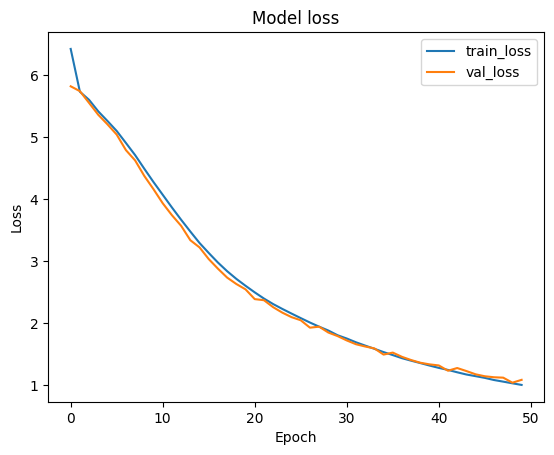

In [8]:
from keras.utils import to_categorical

def data_generator(features, sequences, batch_size, vocab_size):
    num_samples = len(features)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_features = features[i:i+batch_size]
            batch_sequences = sequences[i:i+batch_size]
            batch_labels = to_categorical(batch_sequences, num_classes=vocab_size)
            yield ([batch_features, batch_sequences], batch_labels)

            #yield ([batch_features, batch_sequences], batch_sequences)
# Define model parameters
max_length = 25  # Length of input sequences
vocab_size = 10000  # Vocabulary size
embedding_dim = 256  # Dimension of word embeddings
units = 256  # Number of units in LSTM layers
image_feature_dim = 100352  # Dimension of image features

# Build the model
model = build_model(max_length, vocab_size, embedding_dim, units, image_feature_dim)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Define batch size and number of epochs
batch_size = 32
epochs = 50

# Train-validation split
train_features, val_features, train_seqs, val_seqs = train_test_split(train_features, train_seqs, test_size=0.1)

# Create data generators
train_generator = data_generator(train_features, train_seqs, batch_size,vocab_size)
val_generator = data_generator(val_features, val_seqs, batch_size, vocab_size)

# Train the model
# Train the model
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_features)//batch_size, 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_features)//batch_size)

# Plot training & validation accuracy/loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [9]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

# Function to generate captions
def generate_caption(model, image_feature, tokenizer, max_length):
    caption = []
    input_sequence = np.zeros((1, max_length))
    
    for _ in range(max_length):
        predictions = model.predict([np.array([image_feature]), input_sequence], verbose=0)
        predicted_id = np.argmax(predictions[0, _])
        if predicted_id == 0:  # End token
            break
        caption.append(predicted_id)
        input_sequence[0, _] = predicted_id
    
    return tokenizer.sequences_to_texts([caption])[0]

# Evaluate the model on test data
actual_captions = []
predicted_captions = []

for i in range(len(test_features)):
    image_feature = test_features[i]
    actual_caption = test_df.iloc[i]['image_description']
    predicted_caption = generate_caption(model, image_feature, tokenizer, max_length)
    
    actual_captions.append([actual_caption.split()])
    predicted_captions.append(predicted_caption.split())

# Calculate BLEU score
bleu_score = corpus_bleu(actual_captions, predicted_captions)
print(f"BLEU Score: {bleu_score}")

# Calculate ROUGE score
rouge = Rouge()
rouge_scores = rouge.get_scores([' '.join(pred) for pred in predicted_captions], [' '.join(actual[0]) for actual in actual_captions], avg=True)
print(f"ROUGE Scores: {rouge_scores}")



BLEU Score: 4.1792476860464144e-232
ROUGE Scores: {'rouge-1': {'r': 0.003167441877119296, 'p': 0.06153846153846154, 'f': 0.0059976869244878685}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.003167441877119296, 'p': 0.06153846153846154, 'f': 0.0059976869244878685}}


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

## Model (VIT + GPT2)

In [10]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import ViTFeatureExtractor, ViTModel, GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader, Dataset


# ViT feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

/AAdata1/deepak.yadav/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/AAdata1/deepak.yadav/.local/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
# GPT tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')


In [12]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, tokenizer, max_length):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['image']
        image = image.convert('RGB')
        inputs = self.feature_extractor(images=image, return_tensors='pt')
        image_features = vit_model(**inputs).last_hidden_state.squeeze(0).mean(dim=0)

        caption = self.dataframe.iloc[idx]['image_description']
        caption_tokens = self.tokenizer(caption, return_tensors='pt', padding='max_length', max_length=self.max_length, truncation=True)

        return image_features, caption_tokens.input_ids.squeeze(), caption_tokens.attention_mask.squeeze()

In [13]:
# Create dataset and dataloaders
max_length = 25
epochs = 50
train_dataset = ImageCaptionDataset(df_train, feature_extractor, tokenizer, max_length)
val_dataset = ImageCaptionDataset(df_val, feature_extractor, tokenizer, max_length)
test_dataset = ImageCaptionDataset(df_test, feature_extractor, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [14]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt_model.to(device)
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=5e-5)

In [16]:
for epoch in range(epochs):
    gpt_model.train()
    train_loss = 0

    for image_features, captions, masks in train_loader:
        image_features = image_features.to(device)
        captions = captions.to(device)
        masks = masks.to(device)

        outputs = gpt_model(input_ids=captions, attention_mask=masks, labels=captions)
        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader)}")

    # Validation
    gpt_model.eval()
    val_loss = 0

    with torch.no_grad():
        for image_features, captions, masks in val_loader:
            image_features = image_features.to(device)
            captions = captions.to(device)
            masks = masks.to(device)

            outputs = gpt_model(input_ids=captions, attention_mask=masks, labels=captions)
            val_loss += outputs.loss.item()

    print(f"Validation Loss: {val_loss / len(val_loader)}")


Epoch 1/50, Loss: 0.8155500784113601
Validation Loss: 3.4093897342681885


KeyboardInterrupt: 

In [ ]:

# Text generation with image features as context
def generate_caption(image_features):
    gpt_model.eval()
    image_features = image_features.unsqueeze(0).to(device)
    
    # Generate text conditioned on image features
    input_ids = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)
    generated = gpt_model.generate(input_ids=input_ids, max_new_tokens=25, num_beams=5, early_stopping=True)
    
    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    return generated_text

actual_captions = []
predicted_captions = []

for image_features, captions, masks in test_loader:
    image_features = image_features.to(device)
    captions = captions.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predicted_texts = [generate_caption(image_feature) for image_feature in image_features]
        actual_texts = [tokenizer.decode(caption, skip_special_tokens=True) for caption in captions]

    actual_captions.extend([[text.split()] for text in actual_texts])
    predicted_captions.extend([text.split() for text in predicted_texts])

# Calculate BLEU score
bleu_score = corpus_bleu(actual_captions, predicted_captions)
print(f"BLEU Score: {bleu_score}")

# Calculate ROUGE score
rouge = Rouge()
rouge_scores = rouge.get_scores([' '.join(pred) for pred in predicted_captions], [' '.join(actual[0]) for actual in actual_captions], avg=True)
print(f"ROUGE Scores: {rouge_scores}")
